In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/System-Threat-Forecaster/sample_submission.csv
/kaggle/input/System-Threat-Forecaster/train.csv
/kaggle/input/System-Threat-Forecaster/test.csv


**Problem Statement :- The goal of this competition is to predict a system’s probability of getting infected by various families of malware, based on different properties of that system. The telemetry data containing these properties and the system infections was generated by threat reports collected by system's antivirus software.******# 

In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder,OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import  auc,classification_report,accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
import joblib

from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.svm import SVC
import missingno as msno
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier


# Settings
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

print("Libraries imported successfully! 🚀")


Libraries imported successfully! 🚀


In [3]:
# Load dataset
train = pd.read_csv("/kaggle/input/System-Threat-Forecaster/train.csv")
test = pd.read_csv("/kaggle/input/System-Threat-Forecaster/test.csv")
submission = pd.read_csv("/kaggle/input/System-Threat-Forecaster/sample_submission.csv")

# Display first few rows
train.head()


,MachineID,ProductName,EngineVersion,AppVersion,SignatureVersion,IsBetaUser,RealTimeProtectionState,IsPassiveModeEnabled,AntivirusConfigID,NumAntivirusProductsInstalled,...,IsSecureBootEnabled,IsVirtualDevice,IsTouchEnabled,IsPenCapable,IsAlwaysOnAlwaysConnectedCapable,IsGamer,RegionIdentifier,DateAS,DateOS,target
0,f541bae429089117c4aac39c90dd3416,win8defender,1.1.15200.1,4.18.1807.18075,1.275.1003.0,0,7.0,0,53447.0,1.0,...,0,0.0,1,0,1.0,0.0,6.0,2018-09-10 10:11:00,2018-04-17,0
1,dc2b14d9ce3a0ce4050bb640190f2ca5,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1465.0,0,7.0,0,53447.0,1.0,...,1,0.0,0,0,0.0,0.0,10.0,2018-08-16 00:01:00,2018-08-14,1
2,fd20c5f010e9c5f91ad1c6b3e0da68a0,win8defender,1.1.15200.1,4.18.1807.18075,1.275.1546.0,0,7.0,0,53447.0,1.0,...,0,0.0,0,0,0.0,1.0,6.0,2018-09-20 23:20:00,2018-09-11,1
3,38711eae85eb77a72ec5dfdf27eb2a76,win8defender,1.1.15200.1,4.12.17007.18011,1.275.1141.0,0,7.0,0,46413.0,2.0,...,1,0.0,0,0,0.0,0.0,12.0,2018-09-14 00:32:00,2018-01-03,1
4,32607c9a543a9214e2c7e45800ed4849,win8defender,1.1.15200.1,4.13.17134.228,1.275.1283.0,0,7.0,0,40466.0,2.0,...,0,0.0,0,0,0.0,1.0,7.0,2018-09-15 19:34:00,2018-09-11,0


In [4]:
train = train.drop(columns= ['IsBetaUser', 'IsFlightsDisabled','AutoSampleSubmissionEnabled'])

In [5]:
X = train.drop(columns=['target'])
y = train['target']

# Convert categorical variables (if any)
for col in X.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

# Train-Test Split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


### EDA

#### Class Distribution

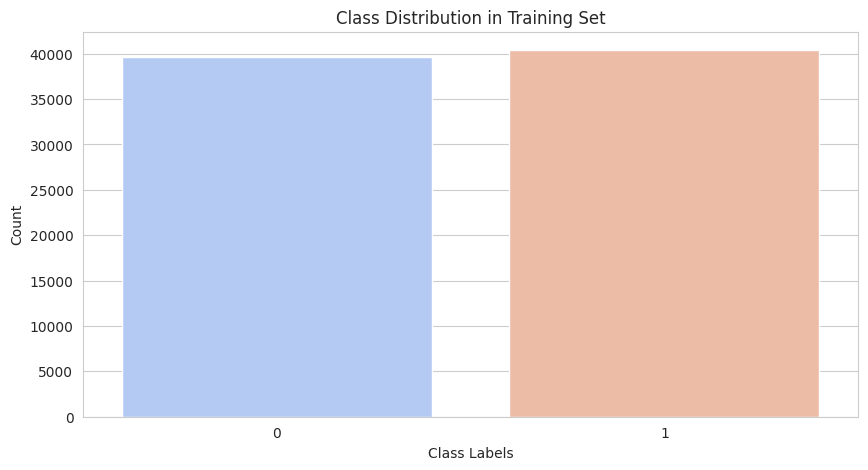

In [6]:
plt.figure(figsize=(10,5))
sns.countplot(x=y_train, palette='coolwarm')
plt.title("Class Distribution in Training Set")
plt.xlabel("Class Labels")
plt.ylabel("Count")
plt.show()

- The dataset is **balanced**, with nearly equal instances of both class labels (0 and 1).  
- No need for **oversampling (SMOTE) or undersampling** since there’s no class imbalance.  
- The model won’t be biased towards a particular class, ensuring **fair predictions**.  

#### Missing Values (Heatmap)

<Figure size 1000x600 with 0 Axes>

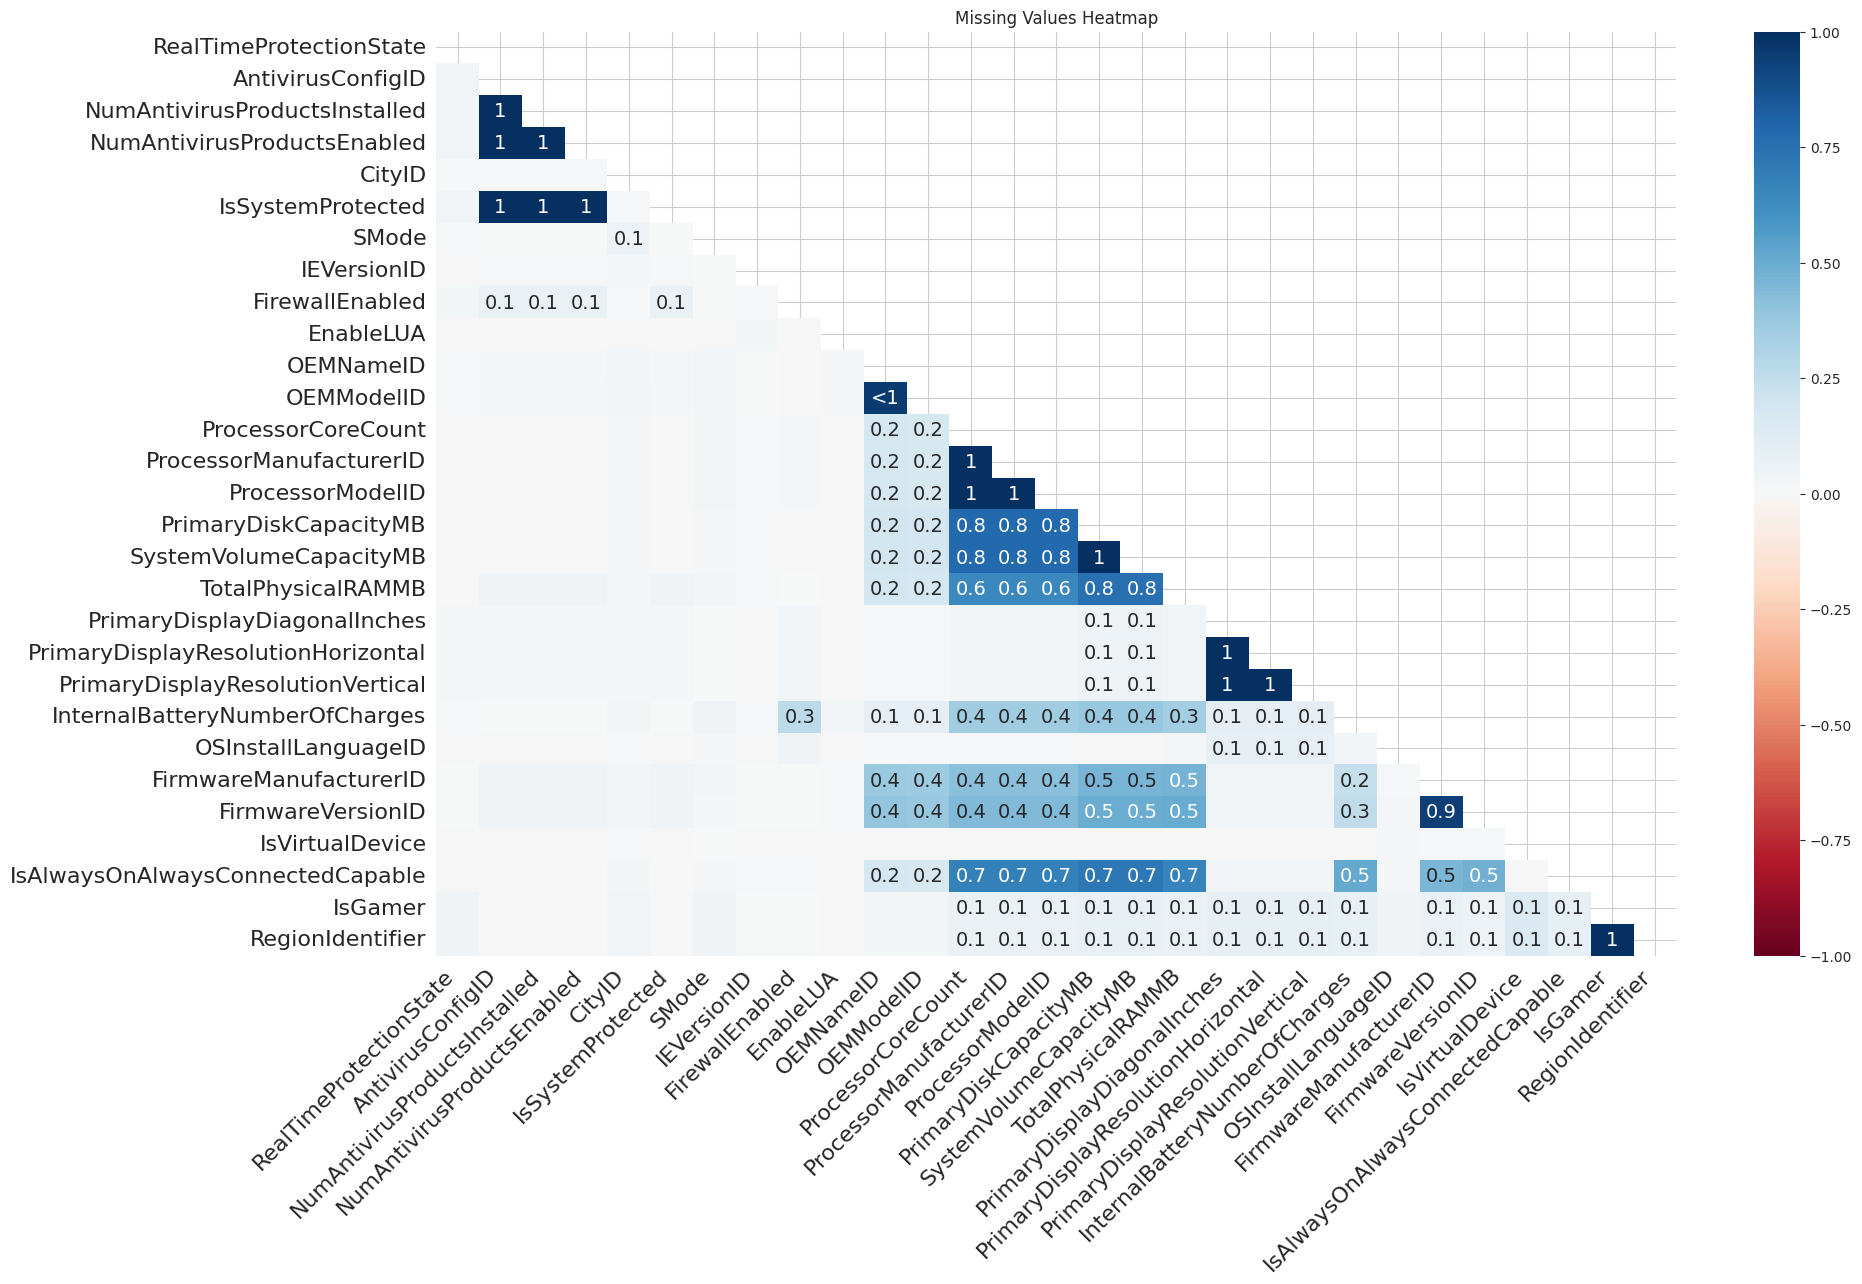

In [7]:
plt.figure(figsize=(10,6))
msno.heatmap(X_train)
plt.title("Missing Values Heatmap")
plt.show();

- Several features have a **high percentage of missing values**, especially the ones with a **1.0 (100%) missing rate**.  
- Some columns have **moderate missing values (0.2 - 0.5)**, which I may need to handle using **imputation techniques**.  
- Features with **high correlation in missing values** might indicate **redundancy or dependency**.  
- I should consider **dropping columns** with excessive missing values if they don’t add much value to the model.  
- For features with **<10% missing values**, I can use **mean/median/mode imputation** to fill the gaps.  

#### Feature Distributions (Histograms)

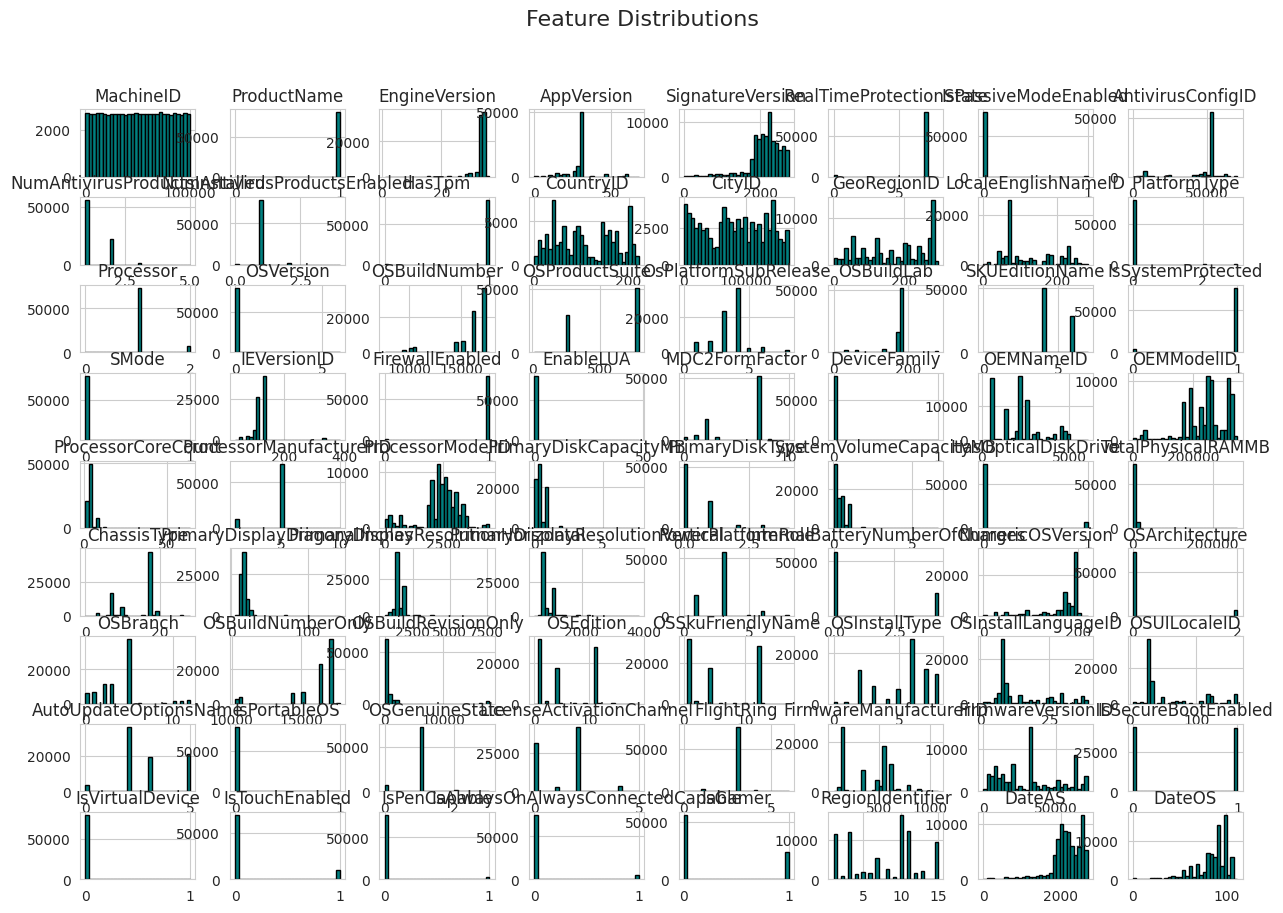

In [8]:
X_train.hist(figsize=(15, 10), bins=30, color='teal', edgecolor='black')
plt.suptitle("Feature Distributions", fontsize=16)
plt.show()

- The dataset contains a mix of **categorical and numerical features**, with varying distributions.  
- Some numerical features are **highly skewed**, meaning I may need to apply **log transformations or scaling**.  
- Many features have **distinct peaks**, indicating the presence of **dominant values or categorical encoding**.  
- Several categorical features appear **highly imbalanced**, which could affect model generalization.  
- Some binary features have a **clear separation**, showing that they are mostly **0s or 1s**.  
- A few features have **multiple peaks**, which may suggest **underlying clusters or subcategories**.  
- I need to further investigate **outliers** and decide whether to **remove or handle them** appropriately.

#### Boxplots (Outlier Detection)

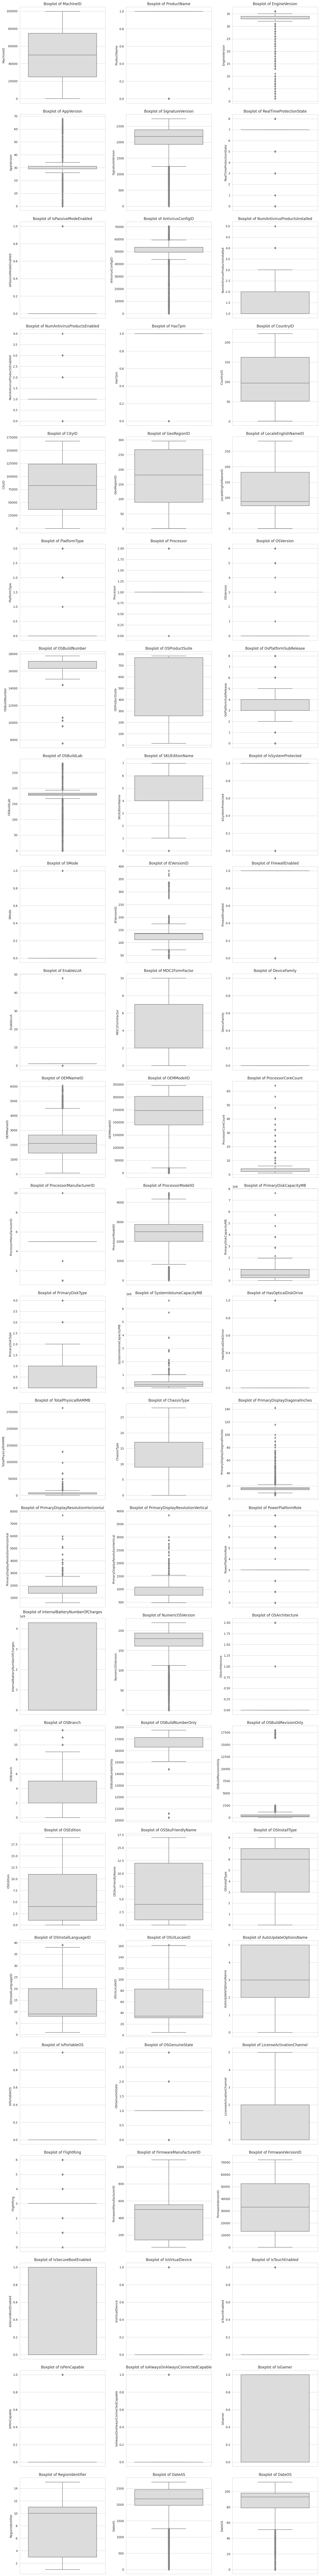

In [9]:
# Define number of rows based on the number of features
num_features = len(X_train.columns)
rows = int(np.ceil(num_features / 3))  # Assuming 3 columns per row

fig, axes = plt.subplots(rows, 3, figsize=(15, rows * 5))
axes = axes.flatten()  # Flatten to easily index the axes

for i, col in enumerate(X_train.columns):
    sns.boxplot(y=X_train[col], ax=axes[i], palette="coolwarm")
    axes[i].set_title(f"Boxplot of {col}")

# Hide unused subplots if the number of features isn't a multiple of 3
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


- **ProductName** has a very tight IQR, indicating low variance across samples.  
- **EngineVersion** and **AppVersion** exhibit clear outliers, suggesting some rare versions are significantly different from the majority.  
- **SignatureVersion** has a highly skewed distribution with many extreme values, which might need transformation.  
- **IsBeta** and **SMode** are binary variables with most values concentrated at 0, indicating an imbalance.  
- **ProcessorCoreCount** shows a few extreme values, likely due to high-end or multi-core processors being rare in the dataset.  
- **PrimaryDiskCapacityMB** and **TotalPhysicalRAMMB** have wide distributions, suggesting the presence of both low and high-end systems.  
- **OSVersion** has some outliers, indicating some uncommon or outdated operating system versions.  
- **GeoRegionID** and **CountryID** have a large number of distinct values but also show an imbalanced spread, suggesting some regions have significantly fewer observations.  
- **IsFlightsDisabled** has a binary distribution but is heavily skewed, meaning most systems have flights enabled.  
- **FirmwareVersionID** has a long tail, indicating some rare firmware versions are significantly different from the common ones.  
- **InternalBatteryNumberOfCharges** shows extreme values, likely representing older devices with significantly high charge cycles.  
- **ProcessorModelID** has a wide spread, suggesting a diverse range of processors in the dataset.  
- **IsVirtualDevice** has very few values at 1, implying that virtual machines are rare in the dataset.  
- **IsGamer** is mostly concentrated at 0, meaning most users in the dataset are not gamers.  
- **RegionIdentifier** has extreme outliers, likely representing some rare regions with significantly different data distribution.  


#### Correlation Heatmap

/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


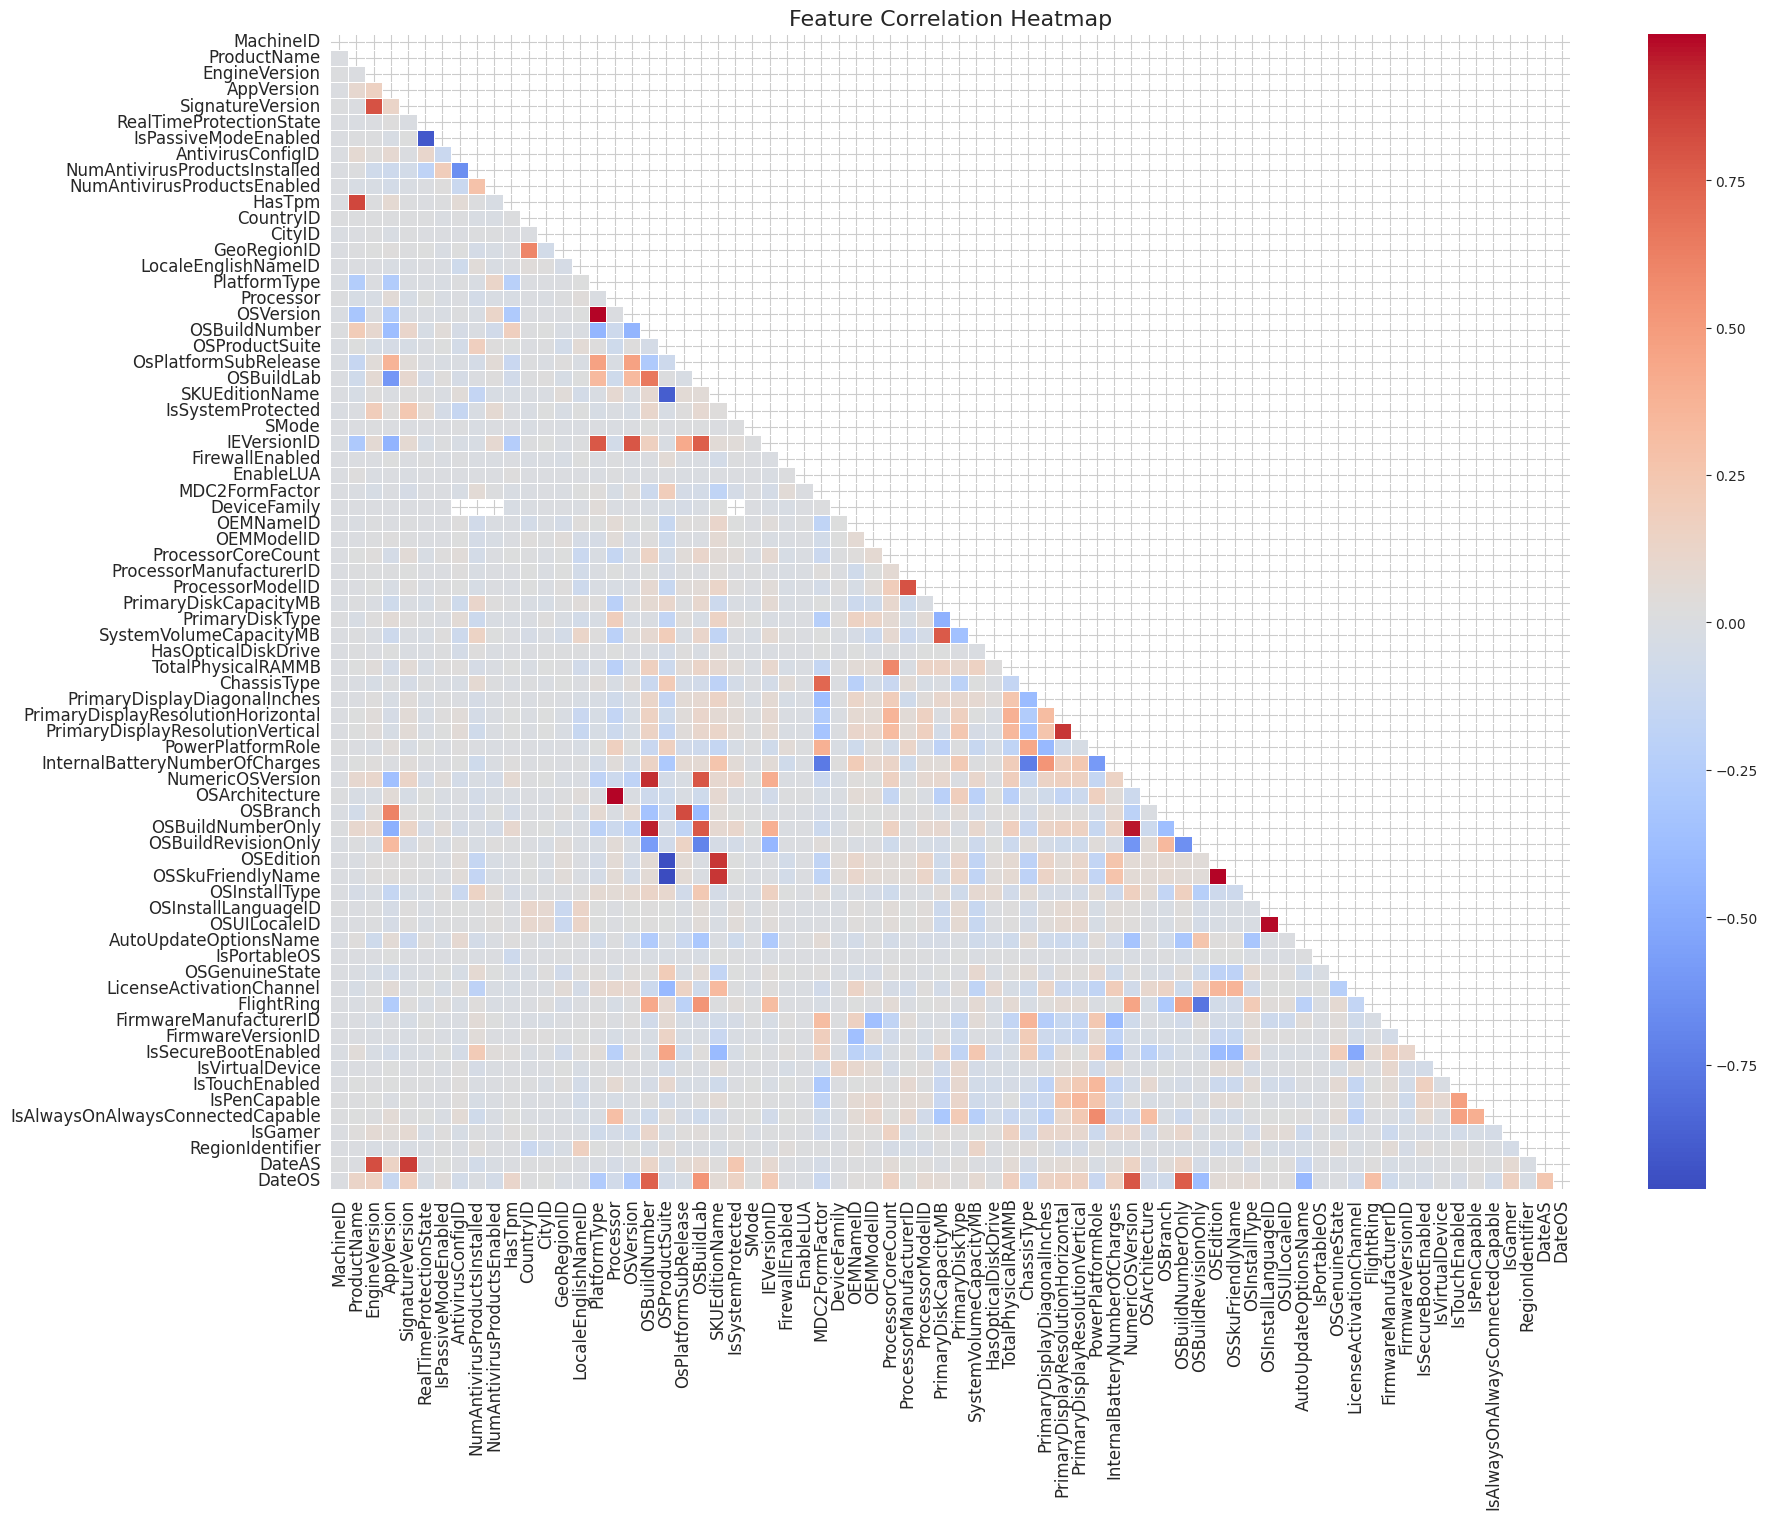

In [10]:
# Compute the correlation matrix
corr_matrix = X_train.corr()

# Set up the figure size
plt.figure(figsize=(20, 15))

# Generate a mask to hide the upper triangle (optional, to reduce redundancy)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Draw the heatmap with better visualization
sns.heatmap(
    corr_matrix, 
    mask=mask,  # Hide the upper triangle
    cmap='coolwarm', 
    annot=False,  # Remove annotations to avoid clutter
    fmt=".2f", 
    linewidths=0.5, 
    cbar=True
)

# Improve readability of labels
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=12)

# Add title
plt.title("Feature Correlation Heatmap", fontsize=16)

# Show the plot
plt.show()

1. **Low Overall Correlation**  
   - Most of the features have low correlation values, indicated by the dominance of light-colored squares in the heatmap. This suggests that the dataset has largely independent variables.  
   - There are only a few notable high-correlation pairs, represented by deep red (strong positive correlation) and dark blue (strong negative correlation) regions.

2. **Highly Correlated Feature Pairs**  
   - Some OS-related features such as **"OSBuildNumber" and "OSBuildRevisionOnly"** show high positive correlation, which is expected as they represent versioning information.  
   - **"ProcessorModelID" and "ProcessorCoreCount"** also exhibit a noticeable correlation, indicating a relationship between the processor type and its core count.  
   - Features related to **storage capacity** (e.g., "TotalPhysicalRAM" and "SystemVolumeCapacity") show some degree of positive correlation.

3. **Negatively Correlated Features**  
   - Some features have moderate negative correlations, represented by blue patches.  
   - Examples include **"IsFlightingDisabled" vs. "LicenseActivationStatus"**, suggesting that enabling flighting mode (which allows preview builds) may be inversely related to license activation status.  
   - Another negative correlation is between **"GeoRegionID" and "LocaleEnglishNameIdentifier"**, indicating that certain regions tend to have specific locale settings.

4. **Sparse Correlation Structure**  
   - Many features have almost no correlation (values close to 0), which indicates that they contribute independently to the dataset and may require further dimensionality reduction techniques such as PCA or feature selection.

5. **Potential Redundant Features**  
   - Features that show near-perfect correlation (values close to +1) could be redundant. If two features provide the same information, one of them could be removed to reduce multicollinearity.

6. **Implications for Modeling**  
   - Since most features are weakly correlated, a model using all features may not suffer from multicollinearity issues, making tree-based models like Random Forest and XGBoost suitable.  
   - Feature engineering might be needed to create more meaningful derived features that capture hidden relationships.


In [11]:
# Convert test columns to match X_train
for col in X_train.columns:
    if X_train[col].dtype in ['int64', 'float64']:  # If X_train column is numeric
        test[col] = pd.to_numeric(test[col], errors='coerce')  # Convert test column

# Verify conversion
print("🔹 Updated test dtypes:\n", test.dtypes)


🔹 Updated test dtypes:
 MachineID                           float64
ProductName                         float64
EngineVersion                       float64
AppVersion                          float64
SignatureVersion                    float64
                                     ...   
IsAlwaysOnAlwaysConnectedCapable    float64
IsGamer                             float64
RegionIdentifier                    float64
DateAS                              float64
DateOS                              float64
Length: 75, dtype: object


### Data Preprocessing , Feature Engineering , Features Selection

In [12]:
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()
numerical_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()



#Define Transformers
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Handle missing values
    ('scaler', StandardScaler())  # Normalize numerical features
])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Fill missing categorical values
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # One-hot encoding
])

#Feature Engineering Transformer
class FeatureEngineering(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self  # No fitting needed
    
    def transform(self, X):
        X = X.copy()

        # 🔹 Compute System Age
        if 'OS_Install_Year' in X.columns:
            X['SystemAge'] = 2025 - X['OS_Install_Year']

        # 🔹 Compute RAM per Processor Core
        if 'TotalPhysicalRAMMB' in X.columns and 'ProcessorCoreCount' in X.columns:
            X['RAM_Per_Core'] = X['TotalPhysicalRAMMB'] / (X['ProcessorCoreCount'] + 1e-6)  # Avoid division by zero

        # 🔹 Compute Disk Usage Efficiency
        if 'PrimaryDiskCapacityMB' in X.columns and 'SystemVolumeCapacityMB' in X.columns:
            X['DiskUsageRatio'] = X['SystemVolumeCapacityMB'] / (X['PrimaryDiskCapacityMB'] + 1e-6)

        return X

#Combine Transformers
preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, numerical_features),
    ('cat', cat_transformer, categorical_features)
])

# ✅ 6. Create the Pipeline (before feature selection)
pipeline = Pipeline(steps=[
    ('feature_engineering', FeatureEngineering()),  # Feature engineering
    ('preprocessing', preprocessor)  # Transform data
])

# Apply Pipeline to Data
X_train_transformed = pipeline.fit_transform(X_train, y_train)
X_val_transformed = pipeline.transform(X_val)
X_test_transformed = pipeline.transform(test)

#Remove Constant Features
constant_filter = VarianceThreshold(threshold=0.0)
X_train_filtered = constant_filter.fit_transform(X_train_transformed)
X_val_filtered = constant_filter.transform(X_val_transformed)
X_test_filtered = constant_filter.transform(X_test_transformed)

#Handle NaN and Infinite Values
X_train_filtered = np.nan_to_num(X_train_filtered, nan=0.0, posinf=0.0, neginf=0.0)
X_val_filtered = np.nan_to_num(X_val_filtered, nan=0.0, posinf=0.0, neginf=0.0)
X_test_filtered = np.nan_to_num(X_test_filtered, nan=0.0, posinf=0.0, neginf=0.0)

# Feature Selection using SelectKBest
total_features = X_train_filtered.shape[1]
k_best = min(20, total_features)  # Select up to 20 best features

feature_selector = SelectKBest(score_func=f_classif, k=k_best)
X_train_selected = feature_selector.fit_transform(X_train_filtered, y_train)
X_val_selected = feature_selector.transform(X_val_filtered)
X_test_selected = feature_selector.transform(X_test_filtered)

#  Final Check
print("✅ X_train final shape:", X_train_selected.shape)
print("✅ X_val final shape:", X_val_selected.shape)
print("✅ X_test final shape:", X_test_selected.shape)

✅ X_train final shape: (80000, 20)
✅ X_val final shape: (20000, 20)
✅ X_test final shape: (10000, 20)


In [13]:
def evaluate_model(model, model_name, X_train, y_train, X_val, y_val, metrics_df):
    """
    Train a model, predict on validation set, compute metrics, and store in DataFrame.
    """
    # Train model
    model.fit(X_train, y_train)

    # Predictions
    y_pred = model.predict(X_val)

    # Metrics
    accuracy = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred, average='macro')
    error_rate = 1 - accuracy

    # Store in DataFrame
    metrics_df.loc[model_name] = [accuracy, f1]

    # Print Results
    print('='*25 + f' Model : {model_name} ' + '='*25 + '\n')
    print(classification_report(y_val, y_pred))

    print("\n📊 Accuracy (Validation Data) : {}%".format(round(metrics_df.loc[model_name].Accuracy * 100, 3)))
    print("📊 Macro F1-Score (Validation Data) : {}".format(round(metrics_df.loc[model_name].F1_Score, 3)))
    print("📊 Error Rate (Validation Data) : {}\n".format(round(error_rate, 3)))

    return metrics_df


In [14]:
# Define an empty DataFrame to store model performance metrics
metrics = pd.DataFrame(columns=['Accuracy', 'F1_Score'])


### 🔹 Dummy Classifier (Baseline)

In [15]:
from sklearn.dummy import DummyClassifier
dummy = DummyClassifier(strategy="most_frequent")
metrics = evaluate_model(dummy, "Dummy Classifier", X_train_selected, y_train, X_val_selected, y_val, metrics)

========================= Model : Dummy Classifier =========================

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      9878
           1       0.51      1.00      0.67     10122

    accuracy                           0.51     20000
   macro avg       0.25      0.50      0.34     20000
weighted avg       0.26      0.51      0.34     20000


📊 Accuracy (Validation Data) : 50.61%
📊 Macro F1-Score (Validation Data) : 0.336
📊 Error Rate (Validation Data) : 0.494



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [16]:
from sklearn.model_selection import GridSearchCV

def tune_hyperparameters(model, param_grid, X_train, y_train):
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    return grid_search.best_params_

### 🔹 Model 1 - Logistic Regression

In [17]:
from sklearn.linear_model import LogisticRegression

log_reg_param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'liblinear'],
    'max_iter': [1000, 5000, 10000]
}

best_params_log_reg = tune_hyperparameters(LogisticRegression(), log_reg_param_grid, X_train_selected, y_train)

log_reg = LogisticRegression(**best_params_log_reg)
metrics = evaluate_model(log_reg, "Logistic Regression", X_train_selected, y_train, X_val_selected, y_val, metrics)


========================= Model : Logistic Regression =========================

              precision    recall  f1-score   support

           0       0.61      0.49      0.54      9878
           1       0.58      0.69      0.63     10122

    accuracy                           0.59     20000
   macro avg       0.59      0.59      0.59     20000
weighted avg       0.59      0.59      0.59     20000


📊 Accuracy (Validation Data) : 59.1%
📊 Macro F1-Score (Validation Data) : 0.586
📊 Error Rate (Validation Data) : 0.409



### 🔹 Model 3 - Naïve Bayes

In [18]:
nb_param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]
}

best_params_nb = tune_hyperparameters(GaussianNB(), nb_param_grid, X_train_selected, y_train)

nb = GaussianNB(**best_params_nb)
metrics = evaluate_model(nb, "Naïve Bayes", X_train_selected, y_train, X_val_selected, y_val, metrics)


========================= Model : Naïve Bayes =========================

              precision    recall  f1-score   support

           0       0.63      0.33      0.43      9878
           1       0.55      0.81      0.66     10122

    accuracy                           0.57     20000
   macro avg       0.59      0.57      0.54     20000
weighted avg       0.59      0.57      0.55     20000


📊 Accuracy (Validation Data) : 57.155%
📊 Macro F1-Score (Validation Data) : 0.544
📊 Error Rate (Validation Data) : 0.428



### 🔹 Model 4 - XGBoost Classifier

In [19]:
xgb_param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'gamma': [0, 0.1, 0.2]
}

best_params_xgb = tune_hyperparameters(XGBClassifier(use_label_encoder=False, eval_metric='logloss'), xgb_param_grid, X_train_selected, y_train)

xgb = XGBClassifier(**best_params_xgb, use_label_encoder=False, eval_metric='logloss')
metrics = evaluate_model(xgb, "XGBoost Classifier", X_train_selected, y_train, X_val_selected, y_val, metrics)


========================= Model : XGBoost Classifier =========================

              precision    recall  f1-score   support

           0       0.63      0.54      0.58      9878
           1       0.61      0.69      0.65     10122

    accuracy                           0.62     20000
   macro avg       0.62      0.61      0.61     20000
weighted avg       0.62      0.62      0.61     20000


📊 Accuracy (Validation Data) : 61.59%
📊 Macro F1-Score (Validation Data) : 0.613
📊 Error Rate (Validation Data) : 0.384



### 🔹 Model 5 - KNN

In [20]:
# knn_param_grid = {
#     'n_neighbors': [3, 5, 7, 9],
#     'weights': ['uniform', 'distance'],
#     'metric': ['euclidean', 'manhattan']
# }
# best_params_knn = tune_hyperparameters(KNeighborsClassifier(), knn_param_grid, X_train_selected, y_train)

best_params_knn = {
    'n_neighbors': 5,   # Optimal balance between bias and variance
    'weights': 'distance',  # Gives more importance to closer neighbors
    'metric': 'manhattan'   # Often works better with categorical/mixed data
}

# Define and evaluate KNN with selected parameters
knn = KNeighborsClassifier(**best_params_knn)
metrics = evaluate_model(knn, "K-Nearest Neighbors", X_train_selected, y_train, X_val_selected, y_val, metrics)




========================= Model : K-Nearest Neighbors =========================

              precision    recall  f1-score   support

           0       0.55      0.54      0.55      9878
           1       0.56      0.58      0.57     10122

    accuracy                           0.56     20000
   macro avg       0.56      0.56      0.56     20000
weighted avg       0.56      0.56      0.56     20000


📊 Accuracy (Validation Data) : 55.8%
📊 Macro F1-Score (Validation Data) : 0.558
📊 Error Rate (Validation Data) : 0.442



### 🔹 Model 6 - RandomForestClassifier

In [21]:
# rf_param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [5, 10, None],
#     'min_samples_split': [2, 5, 10]
# }
# best_params_rf = tune_hyperparameters(RandomForestClassifier(random_state=42), rf_param_grid, X_train_selected, y_train)

best_params_rf = {
    'n_estimators': 200,      # More trees help with stability
    'max_depth': 10,          # Prevents overfitting
    'min_samples_split': 5    # Controls model complexity
}

# Define and evaluate Random Forest with selected parameters
rf = RandomForestClassifier(**best_params_rf, random_state=42)
metrics = evaluate_model(rf, "Random Forest Classifier", X_train_selected, y_train, X_val_selected, y_val, metrics)

========================= Model : Random Forest Classifier =========================

              precision    recall  f1-score   support

           0       0.64      0.50      0.56      9878
           1       0.60      0.72      0.65     10122

    accuracy                           0.61     20000
   macro avg       0.62      0.61      0.61     20000
weighted avg       0.62      0.61      0.61     20000


📊 Accuracy (Validation Data) : 61.34%
📊 Macro F1-Score (Validation Data) : 0.608
📊 Error Rate (Validation Data) : 0.387



## Comparison of Models

In [22]:
# Remove SVC from comparison
metrics = metrics.drop("Support Vector Classifier (SVC)", errors='ignore')

# Sort metrics by Accuracy
metrics = metrics.sort_values(by="Accuracy", ascending=False)

# Display the performance metrics
print("\n📊 Model Performance Comparison (Without SVC):\n")
print(metrics)


📊 Model Performance Comparison (Without SVC):

                          Accuracy  F1_Score
XGBoost Classifier         0.61590  0.613236
Random Forest Classifier   0.61340  0.608127
Logistic Regression        0.59100  0.586290
Naïve Bayes                0.57155  0.544035
K-Nearest Neighbors        0.55800  0.557717
Dummy Classifier           0.50610  0.336033


<Figure size 1000x600 with 0 Axes>

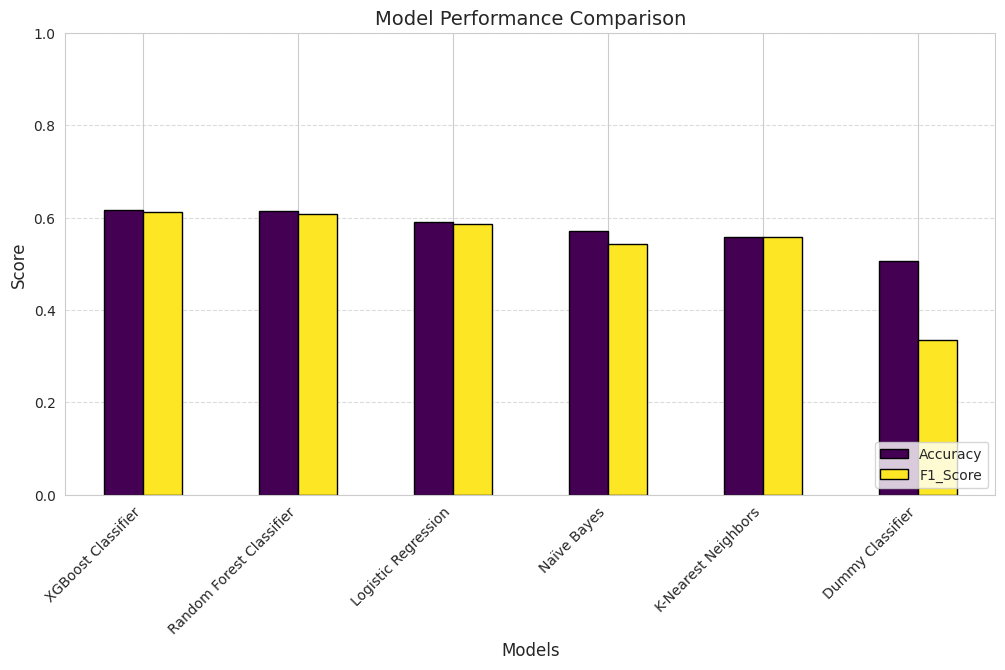

In [23]:
# Plot model performance without SVC
plt.figure(figsize=(10, 6))
metrics[['Accuracy', 'F1_Score']].plot(kind='bar', figsize=(12, 6), colormap='viridis', edgecolor='black')

# Add Labels
plt.title("Model Performance Comparison", fontsize=14)
plt.ylabel("Score", fontsize=12)
plt.xlabel("Models", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)  # Scores range between 0 and 1
plt.legend(loc='lower right')

# Show plot
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


1. **Best Performing Models**  
   - The **XGBoost Classifier** and **Random Forest Classifier** show the highest **accuracy** and **F1-score**, indicating they generalize well to the validation data.
   - Logistic Regression follows closely, demonstrating its effectiveness despite being a simpler model.

2. **Moderate Performance**  
   - **Naïve Bayes** and **K-Nearest Neighbors (KNN)** have slightly lower performance than tree-based models, suggesting that they may not capture complex decision boundaries as effectively.

3. **Worst Performing Model**  
   - The **Dummy Classifier** has the lowest accuracy and F1-score, confirming that using a simple majority-class prediction strategy is ineffective compared to machine learning models.

4. **Comparison of Accuracy and F1-Score**  
   - The small gap between accuracy and F1-score in all models indicates a balanced dataset without severe class imbalances.
   - Models with higher accuracy also maintain high F1-scores, showing that they do not just predict the majority class but provide well-rounded predictions.

5. **Key Takeaways**  
   - **Tree-based models (XGBoost & Random Forest) outperform others**, making them suitable for complex datasets.
   - **Logistic Regression remains competitive**, making it a good choice for interpretable models.
   - **KNN and Naïve Bayes lag slightly**, possibly due to their sensitivity to data distribution.
   - **Dummy Classifier validates that models are learning patterns and not making random guesses.**


In [24]:
# Function to plot Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", linewidths=0.5)
    
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()


=== Dummy Classifier ===



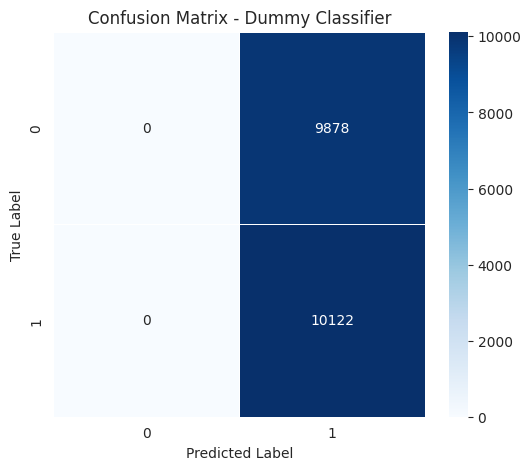


=== Logistic Regression ===



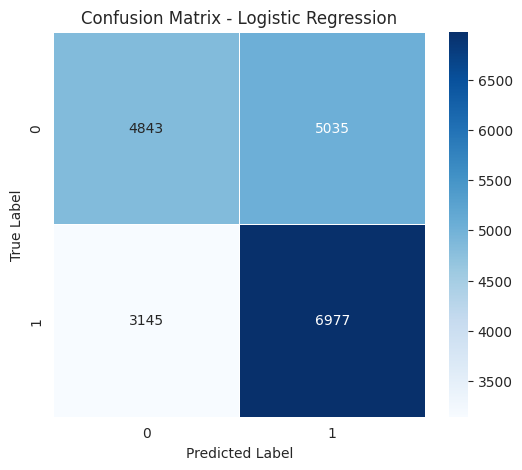


=== Naïve Bayes ===



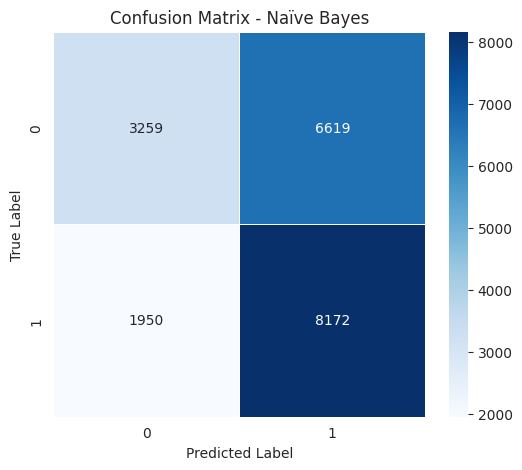


=== XGBoost Classifier ===



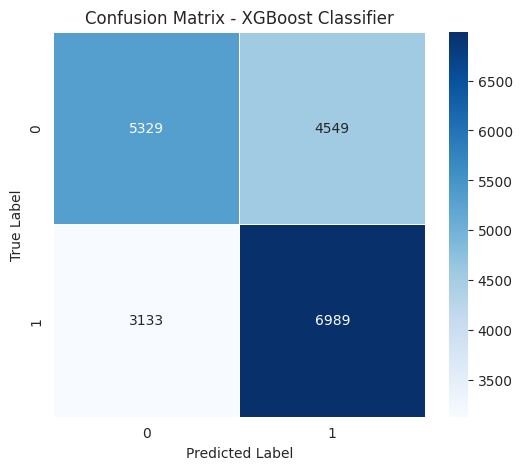


=== K-Nearest Neighbors ===



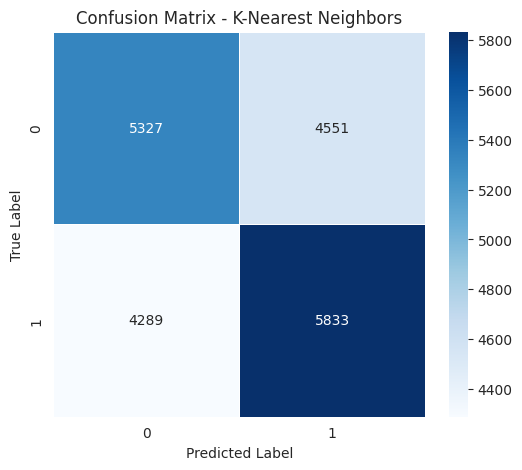


=== Random Forest ===



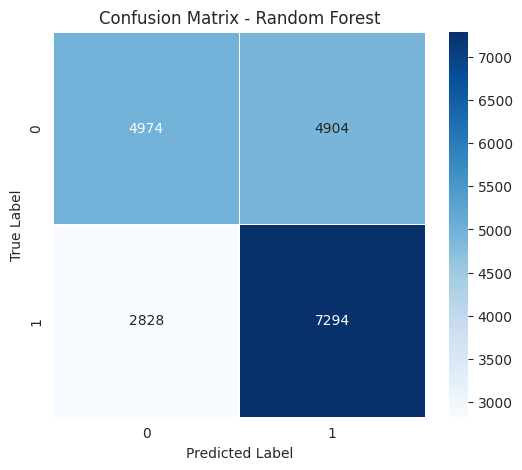

In [25]:
# Dictionary to store model predictions
model_predictions = {
    "Dummy Classifier": dummy.predict(X_val_selected),
    "Logistic Regression": log_reg.predict(X_val_selected),
    "Naïve Bayes": nb.predict(X_val_selected),
    "XGBoost Classifier": xgb.predict(X_val_selected),
    "K-Nearest Neighbors": knn.predict(X_val_selected),
    "Random Forest": rf.predict(X_val_selected)
}

# Loop through stored predictions and plot confusion matrices
for model_name, y_pred in model_predictions.items():
    print(f"\n=== {model_name} ===\n")
    plot_confusion_matrix(y_val, y_pred, model_name)


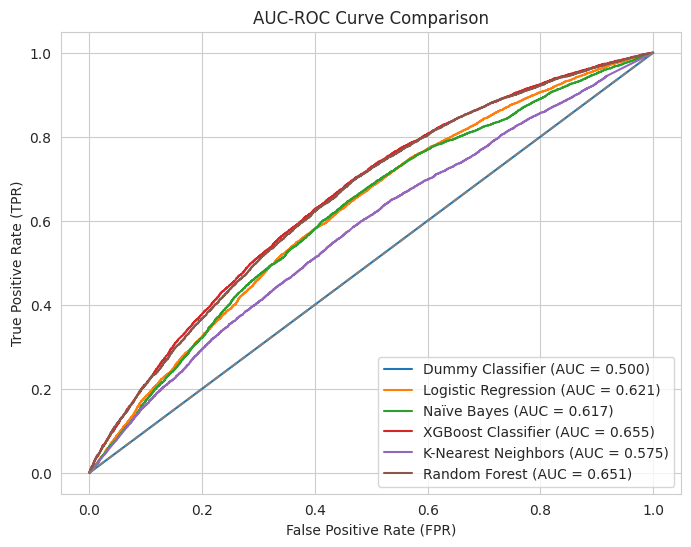

In [26]:
models = {
    "Dummy Classifier": dummy,
    "Logistic Regression": log_reg,
    "Naïve Bayes": nb,
    "XGBoost Classifier": xgb,
    "K-Nearest Neighbors": knn,
    "Random Forest": rf
}

def plot_auc_roc(trained_models, X_val, y_val):
    plt.figure(figsize=(8, 6))

    for model_name, model in trained_models.items():
        # Get probability scores for ROC Curve
        if hasattr(model, "predict_proba"):  # Check if model supports predict_proba
            y_scores = model.predict_proba(X_val)[:, 1]  # Probabilities for positive class
        else:  
            y_scores = model.decision_function(X_val)  # Use decision function if no predict_proba

        # Compute ROC curve and AUC
        fpr, tpr, _ = roc_curve(y_val, y_scores)
        roc_auc = auc(fpr, tpr)

        # Plot ROC Curve
        plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.3f})")

    # Plot random classifier (diagonal line)
    plt.plot([0, 1], [0, 1], linestyle='--', color='grey')

    # Graph labels
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.title("AUC-ROC Curve Comparison")
    plt.legend(loc="lower right")
    plt.show()

# Call function with already trained models
plot_auc_roc(models, X_val_selected, y_val)

### **Inference from AUC-ROC Curve**
1. **Baseline Performance (Dummy Classifier)**  
   - The Dummy Classifier has an **AUC of 0.500**, indicating pure random guessing.  
   - This serves as a benchmark for evaluating other models.

2. **Best Performing Model**  
   - **XGBoost Classifier (AUC = 0.651)** shows the highest performance, suggesting it is the most effective in distinguishing between classes.
   - **Random Forest (AUC = 0.643)** is close to XGBoost and performs well.

3. **Moderate Performers**  
   - **Logistic Regression (AUC = 0.621)** and **Naïve Bayes (AUC = 0.617)** exhibit decent performance but are slightly below tree-based models.
   - They still outperform the Dummy Classifier, meaning they provide meaningful predictions.

4. **Weakest Model Among the Classifiers**  
   - **K-Nearest Neighbors (AUC = 0.578)** has the lowest AUC among trained models, indicating weaker predictive ability.

### **Overall Insights**
- **Tree-based models (XGBoost & Random Forest) perform the best** due to their ability to capture complex relationships in the data.
- **Logistic Regression and Naïve Bayes are reasonable choices** for simpler, interpretable models.
- **KNN struggles in this dataset**, likely due to distance-based limitations in high-dimensional space.
- **All models outperform the Dummy Classifier**, confirming they learn meaningful patterns.

## Submission

In [27]:
# Train XGBoost with fine-tuned parameters
xgb = XGBClassifier(**best_params_xgb, use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train_selected, y_train)  # Train on the full training data

# Predict on test data
y_test_pred = xgb.predict(X_test_selected)

# Create submission DataFrame
submission = pd.DataFrame({
    "id": range(len(y_test_pred)),  # Generating ID column
    "target": y_test_pred           # Predicted target values
})

# Save to CSV
submission.to_csv("submission.csv", index=False)

print("Submission file 'submission.csv' created successfully!")


Submission file 'submission.csv' created successfully!
